# Anac flight delay prediction

## Data Loading and Integration

This section loads the Brazilian ANAC VRA (Active Regular Flights) open dataset directly from the official data source.  
Monthly CSV files are dynamically retrieved for the selected year, validated for availability, and merged into a single DataFrame for further analysis.


In [ ]:
import pandas as pd
import requests
from urllib.parse import quote

# Base URL for ANAC open VRA (Active Regular Flights) dataset
BASE_URL = (
    "https://sistemas.anac.gov.br/dadosabertos/"
    "Voos%20e%20opera%C3%A7%C3%B5es%20a%C3%A9reas/"
    "Voo%20Regular%20Ativo%20%28VRA%29/"
)

# Month mapping required to match ANAC folder structure
MONTHS = {
    1: "Janeiro",
    2: "Fevereiro",
    3: "Março",
    4: "Abril",
    5: "Maio",
    6: "Junho",
    7: "Julho",
    8: "Agosto",
    9: "Setembro",
    10: "Outubro",
    11: "Novembro",
    12: "Dezembro",
}

# Years selected for analysis
YEARS = [2023,2024,2025]

dfs = []

def file_exists(url):
    """
    Check if a remote file exists before attempting download.
    This avoids runtime errors caused by missing monthly datasets.
    """
    try:
        r = requests.head(url, timeout=10)
        return r.status_code == 200
    except requests.RequestException:
        return False

# Download and load available monthly datasets
for year in YEARS:
    for month_num, month_name in MONTHS.items():

        folder = f"{month_num:02d} - {month_name}"
        filename = f"VRA_{year}{month_num}.csv"

        url = f"{BASE_URL}{year}/{quote(folder)}/{filename}"

        if not file_exists(url):
            print(f"❌ Missing: {year}-{month_num:02d}")
            continue

        print(f"✔️ Downloading {year}-{month_num:02d}")

        df = pd.read_csv(
            url,
            sep=";",
            encoding="utf-8",
            skiprows=1,
            low_memory=False
        )

        # Add explicit temporal identifiers for downstream analysis
        df["year"] = year
        df["month"] = month_num

        dfs.append(df)

# =========================
# FINAL MERGE
# =========================

# Combine all monthly datasets into a single DataFrame
df_final = pd.concat(dfs, ignore_index=True)

print("✅ All available VRA data merged")
print(df_final.shape)


In [ ]:
df_final.to_parquet('vra_anac_2023_2025.parquet')

In [1]:

import pandas as pd

url = "https://raw.githubusercontent.com/JessePMelo/anac-flight-delay-prediction/v3-climate-integration/data_science/data/raw/vra_anac_2023_2025.parquet"

df = pd.read_parquet(url)

df_final = df.copy()

After loading, all available monthly datasets are consolidated into a single DataFrame, preserving temporal identifiers (`year` and `month`) to support downstream feature engineering and exploratory analysis.


## Initial Dataset Inspection

After consolidating all available monthly files, an initial inspection is performed to understand the dataset structure, column availability, and basic integrity before proceeding with data preparation.


In [2]:
df_final

,ICAO Empresa Aérea,Número Voo,Código Autorização (DI),Código Tipo Linha,ICAO Aeródromo Origem,ICAO Aeródromo Destino,Partida Prevista,Partida Real,Chegada Prevista,Chegada Real,Situação Voo,Código Justificativa,year,month
0,AZU,2913,0,N,SBFZ,SBRF,2023-01-24 05:40:00,2023-01-24 05:32:00,2023-01-24 07:00:00,2023-01-24 06:40:00,REALIZADO,NaN,2023,1
1,AZU,2913,0,N,SBFZ,SBRF,2023-01-25 05:40:00,2023-01-25 05:43:00,2023-01-25 07:00:00,2023-01-25 06:55:00,REALIZADO,NaN,2023,1
2,AZU,2913,0,N,SBFZ,SBRF,2023-01-26 05:40:00,2023-01-26 05:34:00,2023-01-26 07:00:00,2023-01-26 06:51:00,REALIZADO,NaN,2023,1
3,AZU,2913,0,N,SBFZ,SBRF,2023-01-27 05:40:00,2023-01-27 05:39:00,2023-01-27 07:00:00,2023-01-27 06:56:00,REALIZADO,NaN,2023,1
4,AZU,2913,0,N,SBFZ,SBRF,2023-01-28 05:40:00,2023-01-28 05:30:00,2023-01-28 07:00:00,2023-01-28 06:40:00,REALIZADO,NaN,2023,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2975831,TAM,9440,1,C,SBIL,SBGR,None,2025-12-31 16:12:00,None,2025-12-31 18:13:00,REALIZADO,NaN,2025,12
2975832,TPA,4057,2,X,SBEG,SKBO,None,2025-12-31 21:46:00,None,2026-01-01 00:24:00,REALIZADO,NaN,2025,12
2975833,TTL,5689,2,C,SBFL,SBPA,None,2025-12-31 05:20:00,None,2025-12-31 06:25:00,REALIZADO,NaN,2025,12
2975834,TTL,9900,6,C,SBRF,SBFZ,None,2025-12-31 09:10:00,None,2025-12-31 10:38:00,REALIZADO,NaN,2025,12


In [4]:
anac_df = df_final.copy()

In [5]:
anac_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2975836 entries, 0 to 2975835
Data columns (total 14 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   ICAO Empresa Aérea       object 
 1   Número Voo               object 
 2   Código Autorização (DI)  object 
 3   Código Tipo Linha        object 
 4   ICAO Aeródromo Origem    object 
 5   ICAO Aeródromo Destino   object 
 6   Partida Prevista         object 
 7   Partida Real             object 
 8   Chegada Prevista         object 
 9   Chegada Real             object 
 10  Situação Voo             object 
 11  Código Justificativa     float64
 12  year                     int64  
 13  month                    int64  
dtypes: float64(1), int64(2), object(11)
memory usage: 317.9+ MB


## Missing Values Assessment

Before applying any transformations or filtering, missing values are evaluated to understand data completeness and identify columns that may require cleaning, imputation, or exclusion.


In [6]:
anac_df.isna().sum()

,0
ICAO Empresa Aérea,0
Número Voo,0
Código Autorização (DI),0
Código Tipo Linha,474
ICAO Aeródromo Origem,0
ICAO Aeródromo Destino,0
Partida Prevista,96005
Partida Real,123846
Chegada Prevista,96007
Chegada Real,123846


The inspection shows that missing values are concentrated in a limited set of operational columns.  
These results guide subsequent filtering and cleaning decisions applied in the data preparation stage.


## Removal of Irrelevant and Non-Informative Columns

Some columns in the original dataset do not contribute to the delay prediction objective or are outside the scope of the current analysis. These fields are removed to reduce noise and simplify downstream processing.


In [7]:
anac_df = anac_df.drop(columns=[

    'Código Justificativa',
    'Chegada Prevista',
])


## Filtering Completed Flights

Only flights with status `REALIZADO` (completed flights) are retained for analysis.  
Canceled or non-completed flights are excluded, as departure delay cannot be reliably measured for these cases.


In [8]:
anac_df = anac_df[anac_df['Situação Voo']=='REALIZADO'].copy()

In [9]:
anac_df

,ICAO Empresa Aérea,Número Voo,Código Autorização (DI),Código Tipo Linha,ICAO Aeródromo Origem,ICAO Aeródromo Destino,Partida Prevista,Partida Real,Chegada Real,Situação Voo,year,month
0,AZU,2913,0,N,SBFZ,SBRF,2023-01-24 05:40:00,2023-01-24 05:32:00,2023-01-24 06:40:00,REALIZADO,2023,1
1,AZU,2913,0,N,SBFZ,SBRF,2023-01-25 05:40:00,2023-01-25 05:43:00,2023-01-25 06:55:00,REALIZADO,2023,1
2,AZU,2913,0,N,SBFZ,SBRF,2023-01-26 05:40:00,2023-01-26 05:34:00,2023-01-26 06:51:00,REALIZADO,2023,1
3,AZU,2913,0,N,SBFZ,SBRF,2023-01-27 05:40:00,2023-01-27 05:39:00,2023-01-27 06:56:00,REALIZADO,2023,1
4,AZU,2913,0,N,SBFZ,SBRF,2023-01-28 05:40:00,2023-01-28 05:30:00,2023-01-28 06:40:00,REALIZADO,2023,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2975831,TAM,9440,1,C,SBIL,SBGR,None,2025-12-31 16:12:00,2025-12-31 18:13:00,REALIZADO,2025,12
2975832,TPA,4057,2,X,SBEG,SKBO,None,2025-12-31 21:46:00,2026-01-01 00:24:00,REALIZADO,2025,12
2975833,TTL,5689,2,C,SBFL,SBPA,None,2025-12-31 05:20:00,2025-12-31 06:25:00,REALIZADO,2025,12
2975834,TTL,9900,6,C,SBRF,SBFZ,None,2025-12-31 09:10:00,2025-12-31 10:38:00,REALIZADO,2025,12


This filtering step ensures consistency between the target variable definition and the operational scope of the dataset.


## Removal of Incomplete Records

Records containing missing values are removed to ensure data consistency and avoid introducing bias through artificial imputation.  
Given the operational nature of the dataset, incomplete records cannot be reliably corrected and are excluded from further analysis.


In [10]:
anac_df = anac_df.dropna()

In [11]:
anac_df

,ICAO Empresa Aérea,Número Voo,Código Autorização (DI),Código Tipo Linha,ICAO Aeródromo Origem,ICAO Aeródromo Destino,Partida Prevista,Partida Real,Chegada Real,Situação Voo,year,month
0,AZU,2913,0,N,SBFZ,SBRF,2023-01-24 05:40:00,2023-01-24 05:32:00,2023-01-24 06:40:00,REALIZADO,2023,1
1,AZU,2913,0,N,SBFZ,SBRF,2023-01-25 05:40:00,2023-01-25 05:43:00,2023-01-25 06:55:00,REALIZADO,2023,1
2,AZU,2913,0,N,SBFZ,SBRF,2023-01-26 05:40:00,2023-01-26 05:34:00,2023-01-26 06:51:00,REALIZADO,2023,1
3,AZU,2913,0,N,SBFZ,SBRF,2023-01-27 05:40:00,2023-01-27 05:39:00,2023-01-27 06:56:00,REALIZADO,2023,1
4,AZU,2913,0,N,SBFZ,SBRF,2023-01-28 05:40:00,2023-01-28 05:30:00,2023-01-28 06:40:00,REALIZADO,2023,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2975753,ACA,0096,0,I,CYUL,SBGR,2025-12-20 22:55:00,2025-12-20 23:35:00,2025-12-21 08:56:00,REALIZADO,2025,12
2975754,ACA,0096,0,I,CYUL,SBGR,2025-12-21 22:55:00,2025-12-21 22:59:00,2025-12-22 08:55:00,REALIZADO,2025,12
2975755,ACA,0096,0,I,CYUL,SBGR,2025-12-22 22:55:00,2025-12-22 23:10:00,2025-12-23 09:26:00,REALIZADO,2025,12
2975756,ACA,0096,0,I,CYUL,SBGR,2025-12-23 22:55:00,2025-12-23 23:04:00,2025-12-24 09:23:00,REALIZADO,2025,12


In [12]:
anac_df.isna().sum()

,0
ICAO Empresa Aérea,0
Número Voo,0
Código Autorização (DI),0
Código Tipo Linha,0
ICAO Aeródromo Origem,0
ICAO Aeródromo Destino,0
Partida Prevista,0
Partida Real,0
Chegada Real,0
Situação Voo,0


This step results in a clean dataset where all remaining records contain the minimum required information for delay calculation and feature engineering.


## Data Type Standardization

Data types are explicitly standardized to ensure semantic correctness, memory efficiency, and compatibility with downstream feature engineering and modeling steps.


In [13]:
# Create an explicit copy to avoid chained assignment issues
anac_df = anac_df.copy()

# Columns representing identifiers and categorical attributes
category_cols = [
    'ICAO Empresa Aérea',
    'Número Voo',
    'ICAO Aeródromo Origem',
    'ICAO Aeródromo Destino',
    'Situação Voo',
    'Código Autorização (DI)',
    'Código Tipo Linha'
]

# Cast categorical features to pandas 'category' dtype
anac_df[category_cols] = anac_df[category_cols].astype('category')

# Datetime columns used for delay calculation and temporal feature extraction
datetime_cols = [
    'Partida Prevista',
    'Partida Real'
]


Explicit type casting ensures consistent behavior across the data preparation pipeline and prevents ambiguity during feature extraction and modeling.


In [14]:
anac_df[category_cols] = anac_df[category_cols].astype('category')

In [15]:
anac_df[datetime_cols] = anac_df[datetime_cols].apply(
    pd.to_datetime,
    dayfirst=True,
    errors='coerce'
)

/tmp/ipython-input-3052966532.py:1: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  anac_df[datetime_cols] = anac_df[datetime_cols].apply(
/tmp/ipython-input-3052966532.py:1: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  anac_df[datetime_cols] = anac_df[datetime_cols].apply(


In [16]:
anac_df['year'] = anac_df['year'].astype('int16')
anac_df['month'] = anac_df['month'].astype('int8')

In [17]:
anac_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2755985 entries, 0 to 2975757
Data columns (total 12 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   ICAO Empresa Aérea       category      
 1   Número Voo               category      
 2   Código Autorização (DI)  category      
 3   Código Tipo Linha        category      
 4   ICAO Aeródromo Origem    category      
 5   ICAO Aeródromo Destino   category      
 6   Partida Prevista         datetime64[ns]
 7   Partida Real             datetime64[ns]
 8   Chegada Real             object        
 9   Situação Voo             category      
 10  year                     int16         
 11  month                    int8          
dtypes: category(7), datetime64[ns](2), int16(1), int8(1), object(1)
memory usage: 121.2+ MB


## Departure Delay Calculation

The departure delay is computed as the difference between the actual and scheduled departure times.  
This continuous variable represents the foundation for defining the target variable and supports both exploratory analysis and feature engineering.


In [18]:
anac_df['Partida Real'] = pd.to_datetime(anac_df['Partida Real'], errors='coerce')
anac_df['Partida Prevista'] = pd.to_datetime(anac_df['Partida Prevista'], errors='coerce')

In [19]:
anac_df['delay_minutes'] = (
    anac_df['Partida Real'] - anac_df['Partida Prevista']
).dt.total_seconds() / 60


Positive values indicate delayed departures, while negative values represent early departures.  
This feature is used exclusively for target definition and exploratory analysis and is excluded from the modeling feature set to prevent data leakage.


## Target Variable Definition

A binary target variable is defined based on a delay threshold of 15 minutes.  
Flights departing more than 15 minutes after the scheduled time are labeled as delayed.


In [20]:
anac_df['is_delayed'] = (anac_df['delay_minutes'] > 15).astype('int8')

This binary formulation enables the use of classification models such as logistic regression, while maintaining interpretability and alignment with common operational delay definitions.


## Day of Week Extraction

The day of the week is extracted from the scheduled departure time to capture weekly operational patterns that may influence flight delays.


In [21]:
anac_df

,ICAO Empresa Aérea,Número Voo,Código Autorização (DI),Código Tipo Linha,ICAO Aeródromo Origem,ICAO Aeródromo Destino,Partida Prevista,Partida Real,Chegada Real,Situação Voo,year,month,delay_minutes,is_delayed
0,AZU,2913,0,N,SBFZ,SBRF,2023-01-24 05:40:00,2023-01-24 05:32:00,2023-01-24 06:40:00,REALIZADO,2023,1,-8.0,0
1,AZU,2913,0,N,SBFZ,SBRF,2023-01-25 05:40:00,2023-01-25 05:43:00,2023-01-25 06:55:00,REALIZADO,2023,1,3.0,0
2,AZU,2913,0,N,SBFZ,SBRF,2023-01-26 05:40:00,2023-01-26 05:34:00,2023-01-26 06:51:00,REALIZADO,2023,1,-6.0,0
3,AZU,2913,0,N,SBFZ,SBRF,2023-01-27 05:40:00,2023-01-27 05:39:00,2023-01-27 06:56:00,REALIZADO,2023,1,-1.0,0
4,AZU,2913,0,N,SBFZ,SBRF,2023-01-28 05:40:00,2023-01-28 05:30:00,2023-01-28 06:40:00,REALIZADO,2023,1,-10.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2975753,ACA,0096,0,I,CYUL,SBGR,2025-12-20 22:55:00,2025-12-20 23:35:00,2025-12-21 08:56:00,REALIZADO,2025,12,40.0,1
2975754,ACA,0096,0,I,CYUL,SBGR,2025-12-21 22:55:00,2025-12-21 22:59:00,2025-12-22 08:55:00,REALIZADO,2025,12,4.0,0
2975755,ACA,0096,0,I,CYUL,SBGR,2025-12-22 22:55:00,2025-12-22 23:10:00,2025-12-23 09:26:00,REALIZADO,2025,12,15.0,0
2975756,ACA,0096,0,I,CYUL,SBGR,2025-12-23 22:55:00,2025-12-23 23:04:00,2025-12-24 09:23:00,REALIZADO,2025,12,9.0,0


In [22]:
anac_df['day_of_week'] = (
    anac_df['Partida Real']
    .dt.dayofweek
    .astype('Int8')
)


The feature ranges from 0 (Monday) to 6 (Sunday) and allows the model to learn differences in delay behavior across weekdays and weekends.


## Temporal Feature Engineering

Multiple calendar-based features are derived from the scheduled departure time to capture seasonal, weekly, and intraday patterns associated with flight delays.


In [23]:
anac_df['week_of_year'] = (
    anac_df['Partida Real']
    .dt.isocalendar()
    .week
    .astype('Int8')
)


In [24]:
anac_df['week_of_month'] = (
    ((anac_df['Partida Real'].dt.day - 1) // 7 + 1)
    .astype('Int8')
)


In [25]:
anac_df['hour'] = (
    anac_df['Partida Real']
    .dt.hour
    .astype('Int8')
)


In [26]:
anac_df['is_weekend'] = (
    anac_df['day_of_week'] >= 5
).astype('Int8')


In [27]:
anac_df['day_of_year'] = (
    anac_df['Partida Real']
    .dt.dayofyear
    .astype('Int16')
)


In [30]:
import pandas as pd
import holidays

# Garantir datetime
anac_df['Partida Prevista'] = pd.to_datetime(
    anac_df['Partida Prevista'],
    errors='coerce'
)

# Datas normalizadas
dates = anac_df['Partida Prevista'].dt.normalize()

# 🔥 Pegar anos reais do dataset
years = dates.dt.year.dropna().unique()

# Criar calendário apenas para esses anos
br_holidays = holidays.Brazil(years=years)

# Converter para DatetimeIndex
holiday_dates = pd.DatetimeIndex(br_holidays.keys()).normalize()

# ------------------------
# Features
# ------------------------

anac_df['is_holiday'] = (
    dates.isin(holiday_dates)
    .astype('Int8')
)

anac_df['is_pre_holiday'] = (
    (dates + pd.Timedelta(days=1))
    .isin(holiday_dates)
    .astype('Int8')
)

anac_df['is_post_holiday'] = (
    (dates - pd.Timedelta(days=1))
    .isin(holiday_dates)
    .astype('Int8')
)


In [31]:
anac_df[['is_holiday', 'is_pre_holiday', 'is_post_holiday']].sum()

,0
is_holiday,64415
is_pre_holiday,67574
is_post_holiday,65954


In [32]:
anac_df

,ICAO Empresa Aérea,Número Voo,Código Autorização (DI),Código Tipo Linha,ICAO Aeródromo Origem,ICAO Aeródromo Destino,Partida Prevista,Partida Real,Chegada Real,Situação Voo,...,is_delayed,day_of_week,week_of_year,week_of_month,hour,is_weekend,day_of_year,is_holiday,is_pre_holiday,is_post_holiday
0,AZU,2913,0,N,SBFZ,SBRF,2023-01-24 05:40:00,2023-01-24 05:32:00,2023-01-24 06:40:00,REALIZADO,...,0,1,4,4,5,0,24,0,0,0
1,AZU,2913,0,N,SBFZ,SBRF,2023-01-25 05:40:00,2023-01-25 05:43:00,2023-01-25 06:55:00,REALIZADO,...,0,2,4,4,5,0,25,0,0,0
2,AZU,2913,0,N,SBFZ,SBRF,2023-01-26 05:40:00,2023-01-26 05:34:00,2023-01-26 06:51:00,REALIZADO,...,0,3,4,4,5,0,26,0,0,0
3,AZU,2913,0,N,SBFZ,SBRF,2023-01-27 05:40:00,2023-01-27 05:39:00,2023-01-27 06:56:00,REALIZADO,...,0,4,4,4,5,0,27,0,0,0
4,AZU,2913,0,N,SBFZ,SBRF,2023-01-28 05:40:00,2023-01-28 05:30:00,2023-01-28 06:40:00,REALIZADO,...,0,5,4,4,5,1,28,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2975753,ACA,0096,0,I,CYUL,SBGR,2025-12-20 22:55:00,2025-12-20 23:35:00,2025-12-21 08:56:00,REALIZADO,...,1,5,51,3,23,1,354,0,0,0
2975754,ACA,0096,0,I,CYUL,SBGR,2025-12-21 22:55:00,2025-12-21 22:59:00,2025-12-22 08:55:00,REALIZADO,...,0,6,51,3,22,1,355,0,0,0
2975755,ACA,0096,0,I,CYUL,SBGR,2025-12-22 22:55:00,2025-12-22 23:10:00,2025-12-23 09:26:00,REALIZADO,...,0,0,52,4,23,0,356,0,0,0
2975756,ACA,0096,0,I,CYUL,SBGR,2025-12-23 22:55:00,2025-12-23 23:04:00,2025-12-24 09:23:00,REALIZADO,...,0,1,52,4,23,0,357,0,0,0


In [35]:
anac_df.columns

Index(['ICAO Empresa Aérea', 'Número Voo', 'Código Autorização (DI)',
       'Código Tipo Linha', 'ICAO Aeródromo Origem', 'ICAO Aeródromo Destino',
       'Partida Prevista', 'Partida Real', 'Chegada Real', 'Situação Voo',
       'year', 'month', 'delay_minutes', 'is_delayed', 'day_of_week',
       'week_of_year', 'week_of_month', 'hour', 'is_weekend', 'day_of_year',
       'is_holiday', 'is_pre_holiday', 'is_post_holiday'],
      dtype='object')

All temporal features are extracted exclusively from scheduled departure times to avoid information leakage and ensure model validity.


## Removal of Leakage-Prone and Non-Modeling Features

Columns that either introduce data leakage or are no longer required after feature extraction are removed to ensure a clean, model-ready dataset.


In [36]:
cols_to_drop = [
    'Partida Real',
    'delay_minutes',
    'Situação Voo',
]

anac_df = anac_df.drop(columns=cols_to_drop)


After this step, the dataset contains only features available at prediction time, fully aligned with the modeling objective.


## Final Dataset Validation

A final inspection is performed to confirm data integrity, data types, and overall readiness for modeling.


In [37]:
anac_df

,ICAO Empresa Aérea,Número Voo,Código Autorização (DI),Código Tipo Linha,ICAO Aeródromo Origem,ICAO Aeródromo Destino,Partida Prevista,Chegada Real,year,month,is_delayed,day_of_week,week_of_year,week_of_month,hour,is_weekend,day_of_year,is_holiday,is_pre_holiday,is_post_holiday
0,AZU,2913,0,N,SBFZ,SBRF,2023-01-24 05:40:00,2023-01-24 06:40:00,2023,1,0,1,4,4,5,0,24,0,0,0
1,AZU,2913,0,N,SBFZ,SBRF,2023-01-25 05:40:00,2023-01-25 06:55:00,2023,1,0,2,4,4,5,0,25,0,0,0
2,AZU,2913,0,N,SBFZ,SBRF,2023-01-26 05:40:00,2023-01-26 06:51:00,2023,1,0,3,4,4,5,0,26,0,0,0
3,AZU,2913,0,N,SBFZ,SBRF,2023-01-27 05:40:00,2023-01-27 06:56:00,2023,1,0,4,4,4,5,0,27,0,0,0
4,AZU,2913,0,N,SBFZ,SBRF,2023-01-28 05:40:00,2023-01-28 06:40:00,2023,1,0,5,4,4,5,1,28,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2975753,ACA,0096,0,I,CYUL,SBGR,2025-12-20 22:55:00,2025-12-21 08:56:00,2025,12,1,5,51,3,23,1,354,0,0,0
2975754,ACA,0096,0,I,CYUL,SBGR,2025-12-21 22:55:00,2025-12-22 08:55:00,2025,12,0,6,51,3,22,1,355,0,0,0
2975755,ACA,0096,0,I,CYUL,SBGR,2025-12-22 22:55:00,2025-12-23 09:26:00,2025,12,0,0,52,4,23,0,356,0,0,0
2975756,ACA,0096,0,I,CYUL,SBGR,2025-12-23 22:55:00,2025-12-24 09:23:00,2025,12,0,1,52,4,23,0,357,0,0,0


In [38]:
anac_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2755985 entries, 0 to 2975757
Data columns (total 20 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   ICAO Empresa Aérea       category      
 1   Número Voo               category      
 2   Código Autorização (DI)  category      
 3   Código Tipo Linha        category      
 4   ICAO Aeródromo Origem    category      
 5   ICAO Aeródromo Destino   category      
 6   Partida Prevista         datetime64[ns]
 7   Chegada Real             object        
 8   year                     int16         
 9   month                    int8          
 10  is_delayed               int8          
 11  day_of_week              Int8          
 12  week_of_year             Int8          
 13  week_of_month            Int8          
 14  hour                     Int8          
 15  is_weekend               Int8          
 16  day_of_year              Int16         
 17  is_holiday               Int8   

## ETL V2

In [39]:
rename_map = {
    'ICAO Empresa Aérea': 'airline',
    'Número Voo': 'flight_number',
    'Código Autorização (DI)': 'authorization_code',
    'Código Tipo Linha': 'line_type',
    'Partida Prevista': 'Scheduled Departure',
    'ICAO Aeródromo Origem': 'origin_airport',
    'ICAO Aeródromo Destino': 'destination_airport',
}

anac_df = anac_df.rename(columns=rename_map)

In [40]:
anac_df = anac_df.astype({
    col: 'string'
    for col in anac_df.select_dtypes(include='category').columns
})


In [41]:
anac_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2755985 entries, 0 to 2975757
Data columns (total 20 columns):
 #   Column               Dtype         
---  ------               -----         
 0   airline              string        
 1   flight_number        string        
 2   authorization_code   string        
 3   line_type            string        
 4   origin_airport       string        
 5   destination_airport  string        
 6   Scheduled Departure  datetime64[ns]
 7   Chegada Real         object        
 8   year                 int16         
 9   month                int8          
 10  is_delayed           int8          
 11  day_of_week          Int8          
 12  week_of_year         Int8          
 13  week_of_month        Int8          
 14  hour                 Int8          
 15  is_weekend           Int8          
 16  day_of_year          Int16         
 17  is_holiday           Int8          
 18  is_pre_holiday       Int8          
 19  is_post_holiday      Int8 

In [42]:
anac_df['route'] = anac_df['origin_airport'].astype('string') + "_" + anac_df['destination_airport'].astype('string')
anac_df['origin_hour'] = anac_df['origin_airport'].astype('string') + "_" + anac_df['hour'].astype('string')

In [43]:
anac_df['isWeekend_hour'] = anac_df['is_weekend'] * anac_df['hour']

anac_df['holiday_hour'] = anac_df['is_holiday'] * anac_df['hour']

anac_df['preholiday_hour'] = anac_df['is_pre_holiday'] * anac_df['hour']

anac_df['postholiday_hour'] = anac_df['is_post_holiday'] * anac_df['hour']

In [44]:
anac_df['airline_hour'] = anac_df['airline'].astype('string') + "_" + anac_df['hour'].astype('string')

In [45]:
anac_df['route_holiday'] = anac_df['route'] + "_" + anac_df['is_holiday'].astype('string')

In [46]:
import numpy as np

anac_df['hour_sin'] = np.sin(2 * np.pi * anac_df['hour'] / 24)
anac_df['hour_cos'] = np.cos(2 * np.pi * anac_df['hour'] / 24)

In [47]:
anac_df['is_first_wave'] = (anac_df['hour'] <= 7).astype(int)
anac_df['is_last_wave'] = (anac_df['hour'] >= 20).astype(int)

Sinal congestionamento

In [48]:
anac_df['origin_volume'] = anac_df.groupby('origin_airport')['origin_airport'].transform('count')

anac_df['destination_volume'] = anac_df.groupby('destination_airport')['destination_airport'].transform('count')

anac_df['route_volume'] = anac_df.groupby('route')['route'].transform('count')

anac_df['airline_delay_rate'] = anac_df.groupby('airline')['is_delayed'].transform('mean')

anac_df['hour_delay_rate'] = anac_df.groupby('hour')['is_delayed'].transform('mean')


## Climate V3

In [49]:
import pandas as pd

url = "https://raw.githubusercontent.com/JessePMelo/anac-flight-delay-prediction/v3-climate-integration/data_science/data/processed/geollicalizacao_lat_lon_codigo_aeroporto.csv"

airport_df = pd.read_csv(url)
airport_df = airport_df[airport_df["airport_code"].str.startswith(("SB", "SD", "SN", "SW"))]




In [50]:
airport_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3157 entries, 31468 to 38991
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   airport_code  3157 non-null   object 
 1   latitude      3157 non-null   float64
 2   longitude     3157 non-null   float64
dtypes: float64(2), object(1)
memory usage: 98.7+ KB


In [51]:
airport_df.head()

,airport_code,latitude,longitude
31468,SB06,-15.848900,-48.982601
31469,SB29,-6.870940,-48.534901
31470,SBA,34.426201,-119.839996
31471,SBAA,-8.348350,-49.301498
31472,SBAC,-4.568896,-37.805135


In [52]:
company_list = anac_df['origin_airport'].unique()
company_list

<StringArray>
['SBFZ', 'SBGR', 'SBRF', 'SBPS', 'SBSR', 'SBIL', 'SBCF', 'SBJP', 'SWBE',
 'SBAE',
 ...
 'KHRL', 'MUGM', 'MTCH', 'SBDO', 'MMGL', 'FNBJ', 'EGPK', 'EGNX', 'SDCO',
 'SAZN']
Length: 376, dtype: string

In [53]:
airport_df = airport_df[
    airport_df['airport_code'].isin(company_list)
]


In [54]:
airport_df.isna().sum()

,0
airport_code,0
latitude,0
longitude,0


In [55]:
url = "https://raw.githubusercontent.com/JessePMelo/anac-flight-delay-prediction/v3-climate-integration/data_science/data/processed/airports.csv"

airport_info = pd.read_csv(url)

airport_info.head()

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,icao_code,iata_code,gps_code,local_code,home_link,wikipedia_link,keywords
0,6523,00A,heliport,Total RF Heliport,40.070985,-74.933689,11.0,NaN,US,US-PA,Bensalem,no,NaN,NaN,K00A,00A,https://www.penndot.pa.gov/TravelInPA/airports...,NaN,NaN
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NaN,US,US-KS,Leoti,no,NaN,NaN,00AA,00AA,NaN,NaN,NaN
2,6524,00AK,small_airport,Lowell Field,59.947733,-151.692524,450.0,NaN,US,US-AK,Anchor Point,no,NaN,NaN,00AK,00AK,NaN,NaN,NaN
3,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NaN,US,US-AL,Harvest,no,NaN,NaN,00AL,00AL,NaN,NaN,NaN
4,506791,00AN,small_airport,Katmai Lodge Airport,59.093287,-156.456699,80.0,NaN,US,US-AK,King Salmon,no,NaN,NaN,00AN,00AN,NaN,NaN,NaN


In [56]:
columns_drop = [
    'id',
    'ident',
    'continent',
    'scheduled_service',
    'home_link',
    'wikipedia_link',
    'keywords'
]

airport_info = airport_info.drop(columns=columns_drop)

In [57]:
airport_info

,type,name,latitude_deg,longitude_deg,elevation_ft,iso_country,iso_region,municipality,icao_code,iata_code,gps_code,local_code
0,heliport,Total RF Heliport,40.070985,-74.933689,11.0,US,US-PA,Bensalem,NaN,NaN,K00A,00A
1,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,US,US-KS,Leoti,NaN,NaN,00AA,00AA
2,small_airport,Lowell Field,59.947733,-151.692524,450.0,US,US-AK,Anchor Point,NaN,NaN,00AK,00AK
3,small_airport,Epps Airpark,34.864799,-86.770302,820.0,US,US-AL,Harvest,NaN,NaN,00AL,00AL
4,small_airport,Katmai Lodge Airport,59.093287,-156.456699,80.0,US,US-AK,King Salmon,NaN,NaN,00AN,00AN
...,...,...,...,...,...,...,...,...,...,...,...,...
84342,medium_airport,Shenyang Dongta Airport,41.784354,123.496308,157.0,CN,CN-21,"Dadong, Shenyang",ZYYY,NaN,ZYYY,NaN
84343,heliport,Sealand Helipad,51.894444,1.482500,40.0,GB,GB-ENG,Sealand,NaN,NaN,NaN,NaN
84344,small_airport,Glorioso Islands Airstrip,-11.584278,47.296389,11.0,TF,TF-U-A,Grande Glorieuse,NaN,NaN,NaN,NaN
84345,small_airport,Fainting Goat Airport,32.110587,-97.356312,690.0,US,US-TX,Blum,NaN,NaN,87TX,87TX


In [58]:
airport_info = airport_info[
    (airport_info['iso_country'] == 'BR')
]


In [59]:
airport_info

,type,name,latitude_deg,longitude_deg,elevation_ft,iso_country,iso_region,municipality,icao_code,iata_code,gps_code,local_code
12951,small_airport,Tatamborá Flying Field,-23.888048,-45.446824,500.0,BR,BR-SP,"Ponta da Sela, Ilhabela",NaN,NaN,NaN,NaN
12952,closed,Alegrete,-29.800278,-55.763054,NaN,BR,BR-RS,NaN,NaN,NaN,NaN,NaN
12953,closed,Fazenda Cana Brava,-17.418400,-39.581799,NaN,BR,BR-BA,NaN,NaN,NaN,NaN,NaN
12954,closed,Fazenda Sao Judas Tadeu,-12.617800,-60.900799,NaN,BR,BR-RO,NaN,NaN,NaN,NaN,NaN
12955,closed,Iguatemi,-23.632900,-54.629700,NaN,BR,BR-MS,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
63704,small_airport,Fazenda do Brejo Airport,-19.254999,-44.473331,2451.0,BR,BR-MG,Paraopeba,NaN,NaN,SWZT,MG0210
63705,small_airport,Fazenda Sete Estrelas Airport,-11.576917,-58.234363,984.0,BR,BR-MT,Brasnorte,NaN,NaN,SWZY,MT0451
63706,heliport,Graer Heliport,-26.263237,-48.858604,39.0,BR,BR-SC,Joinville,NaN,NaN,SWZZ,SC0101
81416,small_airport,Xinguara Municipal Airport,-7.090600,-49.976500,810.0,BR,BR-PA,Xinguara,NaN,XIG,SWSX,PA0150


In [60]:
airport_df

,airport_code,latitude,longitude
31472,SBAC,-4.568896,-37.805135
31473,SBAE,-22.160755,-49.070325
31477,SBAQ,-21.812000,-48.132999
31478,SBAR,-10.984000,-37.070301
31479,SBAT,-9.866389,-56.106298
...,...,...,...
38613,SWLC,-17.834723,-50.956112
38651,SWMW,-3.372170,-57.724800
38713,SWPI,-2.673521,-56.777625
38825,SWTP,-0.378604,-64.992558


In [61]:
len(set(airport_df['airport_code']) &
    set(airport_info['icao_code']))

139

In [62]:
airport_codes = set(airport_df['airport_code'])
info_codes = set(airport_info['icao_code'])

nao_encontrados = airport_codes - info_codes
nao_encontrados


{'SBCO',
 'SBDO',
 'SBJD',
 'SBJI',
 'SBMI',
 'SBPO',
 'SBSG',
 'SBSO',
 'SBUY',
 'SDIY',
 'SDLO',
 'SN6L',
 'SNAB',
 'SNBA',
 'SNCL',
 'SNEB',
 'SNIG',
 'SNJM',
 'SNLN',
 'SNOB',
 'SNRJ',
 'SNSM',
 'SNSS',
 'SNTS',
 'SNWS',
 'SNZR',
 'SWBE',
 'SWKQ',
 'SWYN'}

In [63]:
geo_airport_info = airport_df.merge(
    airport_info,
    left_on=['latitude', 'longitude'],
    right_on=['latitude_deg', 'longitude_deg'],
    how='inner'
)

geo_airport_info.shape


(168, 15)

In [64]:
geo_airport_info['state'] = geo_airport_info['iso_region'].str[-2:]
geo_airport_info.drop(columns=['iso_region'], inplace=True)

In [65]:
geo_airport_info

,airport_code,latitude,longitude,type,name,latitude_deg,longitude_deg,elevation_ft,iso_country,municipality,icao_code,iata_code,gps_code,local_code,state
0,SBAC,-4.568896,-37.805135,medium_airport,Aracati Dragão do Mar Regional Airport,-4.568896,-37.805135,128.0,BR,Aracati,SBAC,ARX,SBAC,CE0004,CE
1,SBAE,-22.160755,-49.070325,medium_airport,Bauru/Arealva–Moussa Nakhal Tobias State Airport,-22.160755,-49.070325,1962.0,BR,Bauru,SBAE,JTC,SBAE,SP0010,SP
2,SBAQ,-21.812000,-48.132999,medium_airport,Araraquara Airport,-21.812000,-48.132999,2334.0,BR,Araraquara,SBAQ,AQA,SBAQ,SP0012,SP
3,SBAR,-10.984000,-37.070301,medium_airport,Aracaju - Santa Maria International Airport,-10.984000,-37.070301,139.0,BR,Aracaju,SBAR,AJU,SBAR,SE0001,SE
4,SBAT,-9.866389,-56.106298,medium_airport,Piloto Osvaldo Marques Dias Airport,-9.866389,-56.106298,948.0,BR,Alta Floresta,SBAT,AFL,SBAT,MT0003,MT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,SWLC,-17.834723,-50.956112,small_airport,General Leite de Castro Airport,-17.834723,-50.956112,2464.0,BR,Rio Verde,SWLC,RVD,SWLC,SWLC,GO
164,SWMW,-3.372170,-57.724800,small_airport,Maués Airport,-3.372170,-57.724800,69.0,BR,Maués,SWMW,MBZ,SWMW,SWMW,AM
165,SWPI,-2.673521,-56.777625,small_airport,Parintins Airport,-2.673521,-56.777625,87.0,BR,Parintins,SWPI,PIN,SWPI,AM0006,AM
166,SWTP,-0.378604,-64.992558,small_airport,Tapuruquara Airport,-0.378604,-64.992558,141.0,BR,Santa Isabel do Rio Negro,SWTP,IRZ,SWTP,AM0022,AM


In [66]:
columns_drop = [
    'name',
    'latitude_deg',
    'longitude_deg',
    'iso_country',
    'icao_code',
    'iata_code',
    'local_code',
    'gps_code'
]
geo_airport_info.drop(columns=columns_drop, inplace=True)


In [67]:
geo_airport_info.isna().sum()

,0
airport_code,0
latitude,0
longitude,0
type,0
elevation_ft,0
municipality,0
state,0


In [68]:
map_regiao = {
    'SP': 'Sudeste', 'RJ': 'Sudeste', 'MG': 'Sudeste', 'ES': 'Sudeste',
    'RS': 'Sul', 'SC': 'Sul', 'PR': 'Sul',
    'BA': 'Nordeste', 'PE': 'Nordeste', 'CE': 'Nordeste', 'RN': 'Nordeste',
    'PB': 'Nordeste', 'AL': 'Nordeste', 'SE': 'Nordeste', 'MA': 'Nordeste', 'PI': 'Nordeste',
    'AM': 'Norte', 'PA': 'Norte', 'AC': 'Norte', 'RO': 'Norte', 'RR': 'Norte', 'AP': 'Norte', 'TO': 'Norte',
    'MT': 'Centro-Oeste', 'MS': 'Centro-Oeste', 'GO': 'Centro-Oeste', 'DF': 'Centro-Oeste'
}

geo_airport_info['region'] = geo_airport_info['state'].map(map_regiao)


In [69]:
geo_origin = geo_airport_info.rename(columns={
    'airport_code': 'origin_airport',
    'type': 'origin_type',
    'elevation_ft': 'origin_elevation_ft',
    'municipality': 'origin_municipality',
    'state': 'origin_state',
    'region': 'origin_region'
})


In [70]:
geo_origin.head()

,origin_airport,latitude,longitude,origin_type,origin_elevation_ft,origin_municipality,origin_state,origin_region
0,SBAC,-4.568896,-37.805135,medium_airport,128.0,Aracati,CE,Nordeste
1,SBAE,-22.160755,-49.070325,medium_airport,1962.0,Bauru,SP,Sudeste
2,SBAQ,-21.812000,-48.132999,medium_airport,2334.0,Araraquara,SP,Sudeste
3,SBAR,-10.984000,-37.070301,medium_airport,139.0,Aracaju,SE,Nordeste
4,SBAT,-9.866389,-56.106298,medium_airport,948.0,Alta Floresta,MT,Centro-Oeste


In [71]:
anac_df.head()

,airline,flight_number,authorization_code,line_type,origin_airport,destination_airport,Scheduled Departure,Chegada Real,year,month,...,route_holiday,hour_sin,hour_cos,is_first_wave,is_last_wave,origin_volume,destination_volume,route_volume,airline_delay_rate,hour_delay_rate
0,AZU,2913,0,N,SBFZ,SBRF,2023-01-24 05:40:00,2023-01-24 06:40:00,2023,1,...,SBFZ_SBRF_0,0.965926,0.258819,1,0,57785,113579,6563,0.143402,0.053112
1,AZU,2913,0,N,SBFZ,SBRF,2023-01-25 05:40:00,2023-01-25 06:55:00,2023,1,...,SBFZ_SBRF_0,0.965926,0.258819,1,0,57785,113579,6563,0.143402,0.053112
2,AZU,2913,0,N,SBFZ,SBRF,2023-01-26 05:40:00,2023-01-26 06:51:00,2023,1,...,SBFZ_SBRF_0,0.965926,0.258819,1,0,57785,113579,6563,0.143402,0.053112
3,AZU,2913,0,N,SBFZ,SBRF,2023-01-27 05:40:00,2023-01-27 06:56:00,2023,1,...,SBFZ_SBRF_0,0.965926,0.258819,1,0,57785,113579,6563,0.143402,0.053112
4,AZU,2913,0,N,SBFZ,SBRF,2023-01-28 05:40:00,2023-01-28 06:40:00,2023,1,...,SBFZ_SBRF_0,0.965926,0.258819,1,0,57785,113579,6563,0.143402,0.053112


In [72]:
anac_df = anac_df.merge(
    geo_origin,
    left_on='origin_airport',
    right_on='origin_airport',
    how='left',
    suffixes=('', '_origin')
)


In [73]:
anac_df = anac_df[anac_df["origin_airport"].str.startswith(("SB", "SD", "SN", "SW"))]

In [74]:
anac_df.head()

,airline,flight_number,authorization_code,line_type,origin_airport,destination_airport,Scheduled Departure,Chegada Real,year,month,...,route_volume,airline_delay_rate,hour_delay_rate,latitude,longitude,origin_type,origin_elevation_ft,origin_municipality,origin_state,origin_region
0,AZU,2913,0,N,SBFZ,SBRF,2023-01-24 05:40:00,2023-01-24 06:40:00,2023,1,...,6563,0.143402,0.053112,-3.775833,-38.532222,large_airport,83.0,Fortaleza,CE,Nordeste
1,AZU,2913,0,N,SBFZ,SBRF,2023-01-25 05:40:00,2023-01-25 06:55:00,2023,1,...,6563,0.143402,0.053112,-3.775833,-38.532222,large_airport,83.0,Fortaleza,CE,Nordeste
2,AZU,2913,0,N,SBFZ,SBRF,2023-01-26 05:40:00,2023-01-26 06:51:00,2023,1,...,6563,0.143402,0.053112,-3.775833,-38.532222,large_airport,83.0,Fortaleza,CE,Nordeste
3,AZU,2913,0,N,SBFZ,SBRF,2023-01-27 05:40:00,2023-01-27 06:56:00,2023,1,...,6563,0.143402,0.053112,-3.775833,-38.532222,large_airport,83.0,Fortaleza,CE,Nordeste
4,AZU,2913,0,N,SBFZ,SBRF,2023-01-28 05:40:00,2023-01-28 06:40:00,2023,1,...,6563,0.143402,0.053112,-3.775833,-38.532222,large_airport,83.0,Fortaleza,CE,Nordeste


In [75]:
df_aux_weather = anac_df[['origin_airport', 'Scheduled Departure','latitude','longitude']].copy()

In [76]:
df_aux_weather

,origin_airport,Scheduled Departure,latitude,longitude
0,SBFZ,2023-01-24 05:40:00,-3.775833,-38.532222
1,SBFZ,2023-01-25 05:40:00,-3.775833,-38.532222
2,SBFZ,2023-01-26 05:40:00,-3.775833,-38.532222
3,SBFZ,2023-01-27 05:40:00,-3.775833,-38.532222
4,SBFZ,2023-01-28 05:40:00,-3.775833,-38.532222
...,...,...,...,...
2755957,SBGR,2025-12-16 21:30:00,-23.431944,-46.467778
2755958,SBGR,2025-12-18 21:30:00,-23.431944,-46.467778
2755959,SBGR,2025-12-23 21:30:00,-23.431944,-46.467778
2755960,SBGR,2025-12-25 21:30:00,-23.431944,-46.467778


In [77]:
df_aux_weather = df_aux_weather.dropna(subset=['Scheduled Departure'])

In [78]:
df_aux_weather = df_aux_weather.copy()
df_aux_weather['weather_lookup_time'] = (
    df_aux_weather['Scheduled Departure'] - pd.Timedelta(hours=1)
).dt.floor('h')


In [79]:
weather_requests = (
    df_aux_weather[['origin_airport', 'latitude', 'longitude', 'weather_lookup_time']]
    .drop_duplicates()
    .sort_values(['origin_airport', 'weather_lookup_time'])
)


In [80]:
weather_requests.to_csv('weather_lookup_time.csv')

In [81]:
start = weather_requests['weather_lookup_time'].min()
end = weather_requests['weather_lookup_time'].max()
start
end

Timestamp('2025-12-31 23:00:00')

In [82]:
import requests
import pandas as pd

lat = -23.43
lon = -46.47

start = weather_requests['weather_lookup_time'].min().strftime('%Y-%m-%d')
end   = weather_requests['weather_lookup_time'].max().strftime('%Y-%m-%d')

url = (
    f"https://archive-api.open-meteo.com/v1/archive?"
    f"latitude={lat}&longitude={lon}"
    f"&start_date={start}&end_date={end}"
    f"&hourly=temperature_2m,precipitation,wind_speed_10m"
)

response = requests.get(url)
data = response.json()

weather_df = pd.DataFrame(data["hourly"])
weather_df.head()


,time,temperature_2m,precipitation,wind_speed_10m
0,2022-12-31T00:00,18.0,0.0,7.5
1,2022-12-31T01:00,18.4,0.0,6.8
2,2022-12-31T02:00,18.1,0.0,8.2
3,2022-12-31T03:00,17.8,0.0,9.1
4,2022-12-31T04:00,17.5,0.0,7.4


In [83]:
airports_unique = (
    df_aux_weather[['origin_airport', 'latitude', 'longitude']]
    .drop_duplicates()
    .reset_index(drop=True)
)

airports_unique.shape


(166, 3)

In [ ]:
import requests
import pandas as pd
import time

start = weather_requests['weather_lookup_time'].min().strftime('%Y-%m-%d')
end   = weather_requests['weather_lookup_time'].max().strftime('%Y-%m-%d')

all_weather = []
failed_airports = []

for idx, row in airports_unique.iterrows():

    airport_code = row['origin_airport']
    lat = round(row['latitude'], 2)
    lon = round(row['longitude'], 2)

    print(f"Download {airport_code} ({idx+1}/{len(airports_unique)})")

    def fetch_weather(lat, lon):
        url = (
            f"https://archive-api.open-meteo.com/v1/archive?"
            f"latitude={lat}&longitude={lon}"
            f"&start_date={start}&end_date={end}"
            f"&hourly=temperature_2m,precipitation,wind_speed_10m"
        )
        response = requests.get(url, timeout=30)
        return response.json()

    try:
        data = fetch_weather(lat, lon)

        # 🔥 Se não vier dados, tenta com 1 casa decimal
        if "hourly" not in data:
            print(f"↪ Retry with 1 decimal for {airport_code}")
            lat_retry = round(lat, 1)
            lon_retry = round(lon, 1)
            data = fetch_weather(lat_retry, lon_retry)

        if "hourly" not in data:
            print(f"⚠️ No data {airport_code}")
            failed_airports.append(airport_code)
            continue

        weather_df = pd.DataFrame(data["hourly"])
        weather_df['weather_lookup_time'] = pd.to_datetime(weather_df['time'])
        weather_df = weather_df.drop(columns=['time'])
        weather_df['airport_code'] = airport_code

        all_weather.append(weather_df)

        time.sleep(1)

    except Exception as e:
        print(f"❌ Error {airport_code}: {e}")
        failed_airports.append(airport_code)
        continue

weather_raw_df = pd.concat(all_weather, ignore_index=True)

print("Fail:", failed_airports)
weather_raw_df.head()


Download SBFZ (1/166)
Download SBGR (2/166)
Download SBRF (3/166)


KeyboardInterrupt: 

In [ ]:
weather_raw_df.to_parquet('weather_raw.parquet')

NameError: name 'weather_raw_df' is not defined

In [84]:
url = "https://raw.githubusercontent.com/JessePMelo/anac-flight-delay-prediction/v3-climate-integration/data_science/data/processed/weather_raw.parquet"

weather_raw_df = pd.read_parquet(url)

In [85]:
weather_raw_df.head()

,temperature_2m,precipitation,wind_speed_10m,weather_lookup_time,airport_code
0,27.0,0.0,17.0,2022-12-31 00:00:00,SBFZ
1,27.0,0.0,19.1,2022-12-31 01:00:00,SBFZ
2,27.0,0.0,22.1,2022-12-31 02:00:00,SBFZ
3,27.0,0.0,22.4,2022-12-31 03:00:00,SBFZ
4,26.9,0.0,20.6,2022-12-31 04:00:00,SBFZ


In [86]:
anac_df.head()

,airline,flight_number,authorization_code,line_type,origin_airport,destination_airport,Scheduled Departure,Chegada Real,year,month,...,route_volume,airline_delay_rate,hour_delay_rate,latitude,longitude,origin_type,origin_elevation_ft,origin_municipality,origin_state,origin_region
0,AZU,2913,0,N,SBFZ,SBRF,2023-01-24 05:40:00,2023-01-24 06:40:00,2023,1,...,6563,0.143402,0.053112,-3.775833,-38.532222,large_airport,83.0,Fortaleza,CE,Nordeste
1,AZU,2913,0,N,SBFZ,SBRF,2023-01-25 05:40:00,2023-01-25 06:55:00,2023,1,...,6563,0.143402,0.053112,-3.775833,-38.532222,large_airport,83.0,Fortaleza,CE,Nordeste
2,AZU,2913,0,N,SBFZ,SBRF,2023-01-26 05:40:00,2023-01-26 06:51:00,2023,1,...,6563,0.143402,0.053112,-3.775833,-38.532222,large_airport,83.0,Fortaleza,CE,Nordeste
3,AZU,2913,0,N,SBFZ,SBRF,2023-01-27 05:40:00,2023-01-27 06:56:00,2023,1,...,6563,0.143402,0.053112,-3.775833,-38.532222,large_airport,83.0,Fortaleza,CE,Nordeste
4,AZU,2913,0,N,SBFZ,SBRF,2023-01-28 05:40:00,2023-01-28 06:40:00,2023,1,...,6563,0.143402,0.053112,-3.775833,-38.532222,large_airport,83.0,Fortaleza,CE,Nordeste


In [87]:
anac_df['Scheduled Departure'] = pd.to_datetime(anac_df['Scheduled Departure'])

anac_df['weather_lookup_time'] = (
    anac_df['Scheduled Departure'] - pd.Timedelta(hours=1)
).dt.floor('h')


In [88]:
weather_raw_df['weather_lookup_time'] = pd.to_datetime(
    weather_raw_df['weather_lookup_time']
)


In [89]:
anac_df = anac_df.merge(
    weather_raw_df,
    left_on=['origin_airport', 'weather_lookup_time'],
    right_on=['airport_code', 'weather_lookup_time'],
    how='left'
)


In [90]:
anac_df.drop(columns=['airport_code'], inplace=True)

In [91]:
anac_df.head()

,airline,flight_number,authorization_code,line_type,origin_airport,destination_airport,Scheduled Departure,Chegada Real,year,month,...,longitude,origin_type,origin_elevation_ft,origin_municipality,origin_state,origin_region,weather_lookup_time,temperature_2m,precipitation,wind_speed_10m
0,AZU,2913,0,N,SBFZ,SBRF,2023-01-24 05:40:00,2023-01-24 06:40:00,2023,1,...,-38.532222,large_airport,83.0,Fortaleza,CE,Nordeste,2023-01-24 04:00:00,25.8,0.0,8.0
1,AZU,2913,0,N,SBFZ,SBRF,2023-01-25 05:40:00,2023-01-25 06:55:00,2023,1,...,-38.532222,large_airport,83.0,Fortaleza,CE,Nordeste,2023-01-25 04:00:00,24.2,0.2,5.0
2,AZU,2913,0,N,SBFZ,SBRF,2023-01-26 05:40:00,2023-01-26 06:51:00,2023,1,...,-38.532222,large_airport,83.0,Fortaleza,CE,Nordeste,2023-01-26 04:00:00,25.0,0.0,6.4
3,AZU,2913,0,N,SBFZ,SBRF,2023-01-27 05:40:00,2023-01-27 06:56:00,2023,1,...,-38.532222,large_airport,83.0,Fortaleza,CE,Nordeste,2023-01-27 04:00:00,25.5,0.0,10.1
4,AZU,2913,0,N,SBFZ,SBRF,2023-01-28 05:40:00,2023-01-28 06:40:00,2023,1,...,-38.532222,large_airport,83.0,Fortaleza,CE,Nordeste,2023-01-28 04:00:00,25.8,0.0,12.6


In [92]:
anac_df.isna().sum()

,0
airline,0
flight_number,0
authorization_code,0
line_type,0
origin_airport,0
destination_airport,0
Scheduled Departure,32034
Chegada Real,0
year,0
month,0


In [93]:
anac_df.shape

(2532854, 48)

In [94]:
anac_df[['temperature_2m','precipitation','wind_speed_10m']].isna().any(axis=1).sum()

np.int64(32034)

In [95]:
anac_df = anac_df.dropna(
    subset=['temperature_2m', 'precipitation', 'wind_speed_10m']
)


In [96]:
anac_df.isna().sum()

,0
airline,0
flight_number,0
authorization_code,0
line_type,0
origin_airport,0
destination_airport,0
Scheduled Departure,0
Chegada Real,0
year,0
month,0


In [97]:
anac_df.head()

,airline,flight_number,authorization_code,line_type,origin_airport,destination_airport,Scheduled Departure,Chegada Real,year,month,...,longitude,origin_type,origin_elevation_ft,origin_municipality,origin_state,origin_region,weather_lookup_time,temperature_2m,precipitation,wind_speed_10m
0,AZU,2913,0,N,SBFZ,SBRF,2023-01-24 05:40:00,2023-01-24 06:40:00,2023,1,...,-38.532222,large_airport,83.0,Fortaleza,CE,Nordeste,2023-01-24 04:00:00,25.8,0.0,8.0
1,AZU,2913,0,N,SBFZ,SBRF,2023-01-25 05:40:00,2023-01-25 06:55:00,2023,1,...,-38.532222,large_airport,83.0,Fortaleza,CE,Nordeste,2023-01-25 04:00:00,24.2,0.2,5.0
2,AZU,2913,0,N,SBFZ,SBRF,2023-01-26 05:40:00,2023-01-26 06:51:00,2023,1,...,-38.532222,large_airport,83.0,Fortaleza,CE,Nordeste,2023-01-26 04:00:00,25.0,0.0,6.4
3,AZU,2913,0,N,SBFZ,SBRF,2023-01-27 05:40:00,2023-01-27 06:56:00,2023,1,...,-38.532222,large_airport,83.0,Fortaleza,CE,Nordeste,2023-01-27 04:00:00,25.5,0.0,10.1
4,AZU,2913,0,N,SBFZ,SBRF,2023-01-28 05:40:00,2023-01-28 06:40:00,2023,1,...,-38.532222,large_airport,83.0,Fortaleza,CE,Nordeste,2023-01-28 04:00:00,25.8,0.0,12.6


import pandas as pd

url = "https://raw.githubusercontent.com/JessePMelo/anac-flight-delay-prediction/v3-climate-integration/data_science/data/processed/anac_df_v3.parquet"

anac_df_v3 = pd.read_parquet(url)

anac_df = anac_df_v3.copy()


In [98]:
anac_df.to_parquet('anac_df_v3-2.parquet')

In [1]:
import pandas as  pd
anac_df = pd.read_parquet('/content/anac_df_v3-2.parquet')

In [2]:
anac_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2500820 entries, 0 to 2532853
Data columns (total 48 columns):
 #   Column               Dtype         
---  ------               -----         
 0   airline              string        
 1   flight_number        string        
 2   authorization_code   string        
 3   line_type            string        
 4   origin_airport       object        
 5   destination_airport  string        
 6   Scheduled Departure  datetime64[ns]
 7   Chegada Real         object        
 8   year                 int16         
 9   month                int8          
 10  is_delayed           int8          
 11  day_of_week          Int8          
 12  week_of_year         Int8          
 13  week_of_month        Int8          
 14  hour                 Int8          
 15  is_weekend           Int8          
 16  day_of_year          Int16         
 17  is_holiday           Int8          
 18  is_pre_holiday       Int8          
 19  is_post_holiday      Int8 

In [3]:
cols_drop = [
    "Scheduled Departure",
    "scheduled_hour",
    "weather_lookup_time",
    "origin_municipality",
    "Chegada Real"
]

anac_df.drop(columns=cols_drop, inplace=True, errors='ignore')


numeric_cols = [
    "origin_volume",
    "destination_volume",
    "route_volume",
    "airline_delay_rate",
    "hour_delay_rate",
    "origin_elevation_ft",
    "temperature_2m",
    "precipitation",
    "wind_speed_10m",
    "hour_sin",
    "hour_cos",
    "latitude",
    "longitude"
]

categorical_cols = [
    "airline",
    "origin_airport",
    'flight_number',
    'authorization_code',
    'line_type',
    "destination_airport",
    "origin_type",
    "origin_state",
    "origin_region"
]

binary_cols = [
    "is_weekend",
    "is_holiday",
    "is_pre_holiday",
    "is_post_holiday",
    "is_first_wave",
    "is_last_wave",
]

# Converter object/string para category
for col in categorical_cols:
    anac_df[col] = anac_df[col].astype("category")

# Binárias para int8
for col in binary_cols:
    anac_df[col] = anac_df[col].astype("int8")

# Numéricas para float32
for col in numeric_cols:
    anac_df[col] = anac_df[col].astype("float32")



In [4]:
anac_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2500820 entries, 0 to 2532853
Data columns (total 44 columns):
 #   Column               Dtype   
---  ------               -----   
 0   airline              category
 1   flight_number        category
 2   authorization_code   category
 3   line_type            category
 4   origin_airport       category
 5   destination_airport  category
 6   year                 int16   
 7   month                int8    
 8   is_delayed           int8    
 9   day_of_week          Int8    
 10  week_of_year         Int8    
 11  week_of_month        Int8    
 12  hour                 Int8    
 13  is_weekend           int8    
 14  day_of_year          Int16   
 15  is_holiday           int8    
 16  is_pre_holiday       int8    
 17  is_post_holiday      int8    
 18  route                string  
 19  origin_hour          string  
 20  isWeekend_hour       Int8    
 21  holiday_hour         Int8    
 22  preholiday_hour      Int8    
 23  postholiday_

In [5]:
sasdasdadas---454
# As correlações individuais são baixas, mas INTERAÇÕES podem explodir!
novas_features = [
    'hour_delay_rate × origin_volume',  # congestionamento na hora problemática
    'airline_delay_rate × hour_delay_rate',  # companhia ruim em hora ruim
    'is_last_wave × origin_volume'  # última onda em aeroporto cheio
]

NameError: name 'sasdasdadas' is not defined

## CORR

In [6]:

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

df = anac_df.copy()

# ============================================================
# 1️⃣ CRITICAL CONGESTION FEATURE
# ============================================================

volume_q90 = df['origin_volume'].quantile(0.90)
hour_delay_q90 = df['hour_delay_rate'].quantile(0.90)

df['critical_congestion'] = (
    (df['origin_volume'] > volume_q90) &
    (df['hour_delay_rate'] > hour_delay_q90)
).astype('int8')



In [18]:
# ============================================================
# ADVANCED FEATURE ENGINEERING (NO SCALING YET)
# ============================================================

df = anac_df.copy()

# ============================================================
# 1️⃣ Interaction: Critical Hour × Weak Airline
# ============================================================

df['critical_hour_x_airline'] = (
    df['hour_delay_rate'] * df['airline_delay_rate']
).astype('float32')



# ============================================================
# 2️⃣ Perfect Storm Flag
# High airport volume + bad historical hour + last wave
# ============================================================

df['perfect_storm_score'] = (
    (df['origin_volume'] / df['origin_volume'].max()) +
    (df['hour_delay_rate'] / df['hour_delay_rate'].max()) +
    df['is_last_wave']
).astype('float32')



# ============================================================
# 3️⃣ Temperature Anomaly (relative to airport baseline)
# ============================================================

airport_mean_temp = df.groupby('origin_airport')['temperature_2m'].transform('mean')

df['temperature_anomaly'] = (
    df['temperature_2m'] - airport_mean_temp
).astype('float32')


# ============================================================
# 4️⃣ Extreme Temperature Flag (top 5% anomaly)
# ============================================================

temp_q95 = df['temperature_anomaly'].abs().quantile(0.95)

df['extreme_temperature_flag'] = (
    df['temperature_anomaly'].abs() > temp_q95
).astype('int8')


# ============================================================
# 5️⃣ Interaction: Volume × Hour Risk
# ============================================================

df['volume_x_hour_risk'] = (
    df['origin_volume'] * df['hour_delay_rate']
).astype('float32')

# ============================================================
# 5️⃣ Interaction: Last_wave × origin_volume
# ============================================================

df['last_wave_x_volume'] = (
    df['is_last_wave'] * df['origin_volume']
).astype('float32')

# ============================================================
# Systemic Delay Pressure (interaction of top interaction features)
# ============================================================

df['systemic_delay_pressure'] = (
    df['critical_hour_x_airline'] *
    df['volume_x_hour_risk']
).astype('float32')


/tmp/ipython-input-1309158268.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  airport_mean_temp = df.groupby('origin_airport')['temperature_2m'].transform('mean')


In [19]:
anac_df = df.copy()

In [20]:
corr_matrix = anac_df.corr(numeric_only=True)

corr_with_target = corr_matrix['is_delayed'].sort_values(ascending=False)

corr_with_target


,is_delayed
is_delayed,1.000000
critical_hour_x_airline,0.177390
hour_delay_rate,0.164027
systemic_delay_pressure,0.154404
volume_x_hour_risk,0.136769
perfect_storm_score,0.135396
hour,0.118140
airline_delay_rate,0.097616
temperature_anomaly,0.088338
origin_volume,0.085144


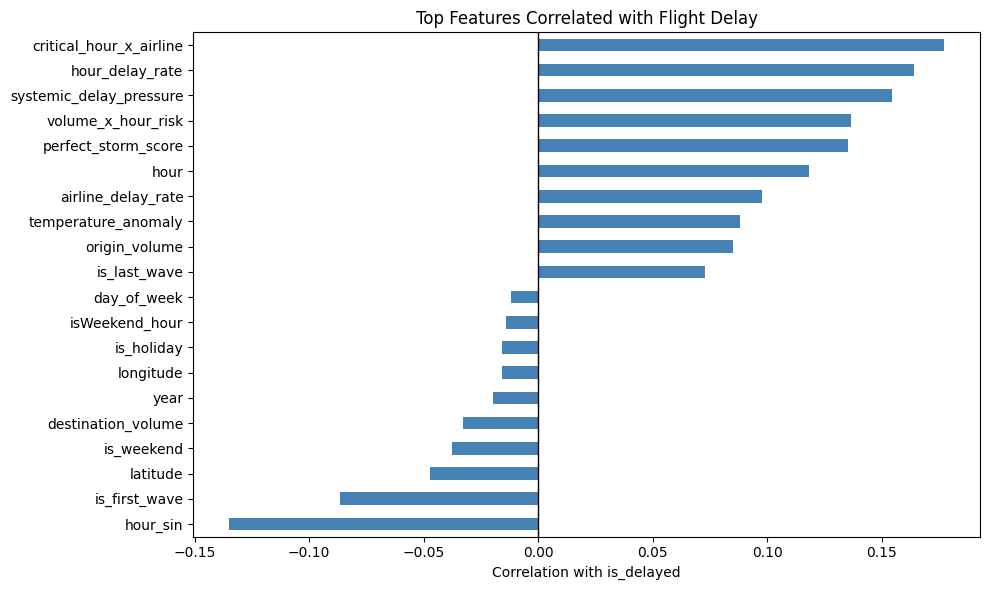

In [21]:
import matplotlib.pyplot as plt

# Correlação com target
corr = anac_df.corr(numeric_only=True)["is_delayed"]

# Remover NaN e o próprio target
corr_clean = corr.dropna().drop("is_delayed")

corr_sorted = corr_clean.sort_values()

# Selecionar top positivos e negativos
top_corr = pd.concat([
    corr_sorted.head(10),
    corr_sorted.tail(10)
])

plt.figure(figsize=(10,6))
top_corr.plot(kind="barh", color="steelblue")
plt.title("Top Features Correlated with Flight Delay")
plt.xlabel("Correlation with is_delayed")
plt.axvline(0, color='black', linewidth=1)
plt.tight_layout()
plt.show()




## VIF

In [22]:
top_flights = (
    anac_df['flight_number']
    .value_counts()
    .head(1000)
    .index
)

anac_df['flight_number'] = anac_df['flight_number'].apply(
    lambda x: x if x in top_flights else 'OTHER'
)


In [24]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import numpy as np

# 1️⃣ Selecionar apenas numéricas (exceto target)
X_vif = (
    anac_df
    .drop(columns=['is_delayed'])
    .select_dtypes(include=['int64', 'Int8', 'Int16', 'float64'])
    .copy()
)

# 2️⃣ Converter tudo para float (obrigatório para VIF)
X_vif = X_vif.astype(float)

# 3️⃣ Remover colunas constantes (evita erro)
X_vif = X_vif.loc[:, X_vif.nunique() > 1]

# 4️⃣ Usar SAMPLE para evitar estouro de RAM
sample_size = 100_000  # pode reduzir para 50_000 se quiser
X_vif_sample = X_vif.sample(
    n=min(sample_size, len(X_vif)),
    random_state=42
)

# 5️⃣ Calcular VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif_sample.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_vif_sample.values, i)
    for i in range(X_vif_sample.shape[1])
]

# 6️⃣ Ordenar
vif_data = vif_data.sort_values(by="VIF", ascending=False)

vif_data


,feature,VIF
1,month,8673.874534
7,day_of_year,7770.590361
0,year,229.071817
4,week_of_month,74.821565
3,week_of_year,71.147670
5,hour,24.597315
6,is_weekend,10.015148
2,day_of_week,8.132374
11,isWeekend_hour,8.014629
10,is_post_holiday,6.226172


In [25]:
anac_df.columns

Index(['airline', 'flight_number', 'authorization_code', 'line_type',
       'origin_airport', 'destination_airport', 'year', 'month', 'is_delayed',
       'day_of_week', 'week_of_year', 'week_of_month', 'hour', 'is_weekend',
       'day_of_year', 'is_holiday', 'is_pre_holiday', 'is_post_holiday',
       'route', 'origin_hour', 'isWeekend_hour', 'holiday_hour',
       'preholiday_hour', 'postholiday_hour', 'airline_hour', 'route_holiday',
       'hour_sin', 'hour_cos', 'is_first_wave', 'is_last_wave',
       'origin_volume', 'destination_volume', 'route_volume',
       'airline_delay_rate', 'hour_delay_rate', 'latitude', 'longitude',
       'origin_type', 'origin_elevation_ft', 'origin_state', 'origin_region',
       'temperature_2m', 'precipitation', 'wind_speed_10m',
       'critical_hour_x_airline', 'perfect_storm_score', 'temperature_anomaly',
       'extreme_temperature_flag', 'volume_x_hour_risk', 'last_wave_x_volume',
       'systemic_delay_pressure'],
      dtype='object')

### Separar grupos de colunas

In [26]:


categorical_cols = [
    'airline',
    'origin_airport',
    'destination_airport',
    'origin_type',
    'origin_state',
    'origin_region'
]



binary_cols = [
    'is_last_wave',
    'extreme_temperature_flag'
]




continuous_cols = [
    'critical_hour_x_airline',
    'hour_delay_rate',
    'systemic_delay_pressure',
    'volume_x_hour_risk',
    'perfect_storm_score',
    'airline_delay_rate',
    'temperature_anomaly',
    'origin_volume',
    'last_wave_x_volume'
]



In [27]:
for col in categorical_cols:
    anac_df[col] = anac_df[col].astype('category')

for col in continuous_cols:
    anac_df[col] = anac_df[col].astype(float)


## Preprocessor

In [28]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

preprocessor = ColumnTransformer(
    transformers=[
        ('cont', StandardScaler(), continuous_cols),
        ('bin', 'passthrough', binary_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)


## Model

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        penalty='l2',
        C=0.5,
        solver='saga',
        max_iter=500,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    ))
])


In [30]:
train = anac_df[anac_df['year'].isin([2023, 2024])].copy()
test  = anac_df[anac_df['year'] == 2025].copy()

X_train = train.drop(columns=['is_delayed','year'])
y_train = train['is_delayed']

X_test = test.drop(columns=['is_delayed','year'])
y_test = test['is_delayed']


TREINAR

In [31]:
model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cont', StandardScaler(),
                                                  ['critical_hour_x_airline',
                                                   'hour_delay_rate',
                                                   'systemic_delay_pressure',
                                                   'volume_x_hour_risk',
                                                   'perfect_storm_score',
                                                   'airline_delay_rate',
                                                   'temperature_anomaly',
                                                   'origin_volume',
                                                   'last_wave_x_volume']),
                                                 ('bin', 'passthrough',
                                                  ['is_last_wave',
                                                   'extreme_temperature_flag']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['airline', 'origin_airport',
                                                   'destination_airport',
                                                   'origin_type',
                                                   'origin_state',
                                                   'origin_region'])])),
                ('classifier',
                 LogisticRegression(C=0.5, class_weight='balanced',
                                    max_iter=500, n_jobs=-1, random_state=42,
                                    solver='saga'))])

In [32]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]


MEtricas


In [33]:
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       0.90      0.60      0.72    705639
           1       0.22      0.61      0.32    128346

    accuracy                           0.60    833985
   macro avg       0.56      0.61      0.52    833985
weighted avg       0.79      0.60      0.66    833985

AUC: 0.6532087348397443


In [ ]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]


In [34]:
import numpy as np
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

for i in range(0, len(thresholds), len(thresholds)//10):
    print(f"Threshold: {thresholds[i]:.3f} | Precision: {precision[i]:.3f} | Recall: {recall[i]:.3f}")


Threshold: 0.110 | Precision: 0.154 | Recall: 1.000
Threshold: 0.292 | Precision: 0.169 | Recall: 0.963
Threshold: 0.353 | Precision: 0.181 | Recall: 0.900
Threshold: 0.405 | Precision: 0.192 | Recall: 0.821
Threshold: 0.450 | Precision: 0.205 | Recall: 0.730
Threshold: 0.492 | Precision: 0.217 | Recall: 0.632
Threshold: 0.532 | Precision: 0.229 | Recall: 0.527
Threshold: 0.571 | Precision: 0.246 | Recall: 0.414
Threshold: 0.607 | Precision: 0.268 | Recall: 0.291
Threshold: 0.651 | Precision: 0.313 | Recall: 0.158
Threshold: 0.966 | Precision: 0.800 | Recall: 0.000


In [37]:
from sklearn.metrics import f1_score

f1_scores = 2 * (precision * recall) / (precision + recall)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print("Best threshold:", best_threshold)
print("Best F1:", f1_scores[best_idx])


Best threshold: 0.4921713167078258
Best F1: 0.32264128025869604


In [38]:
threshold =  0.4921713167078258
y_pred_adjusted = (y_proba >= threshold).astype(int)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_adjusted))



              precision    recall  f1-score   support

           0       0.90      0.58      0.71    705639
           1       0.22      0.63      0.32    128346

    accuracy                           0.59    833985
   macro avg       0.56      0.61      0.52    833985
weighted avg       0.79      0.59      0.65    833985



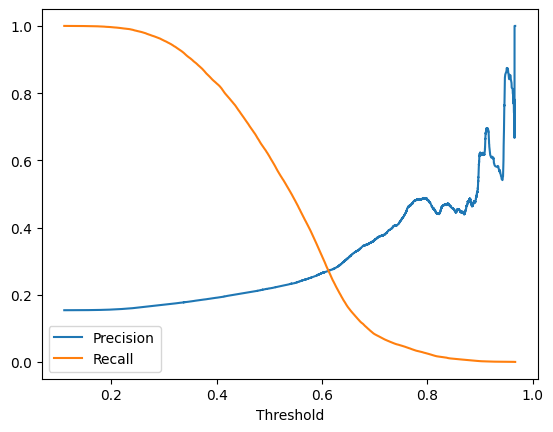

In [39]:
import matplotlib.pyplot as plt

plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.legend()
plt.show()


Best threshold: 0.494949494949495
Best F1: 0.3223478295852275


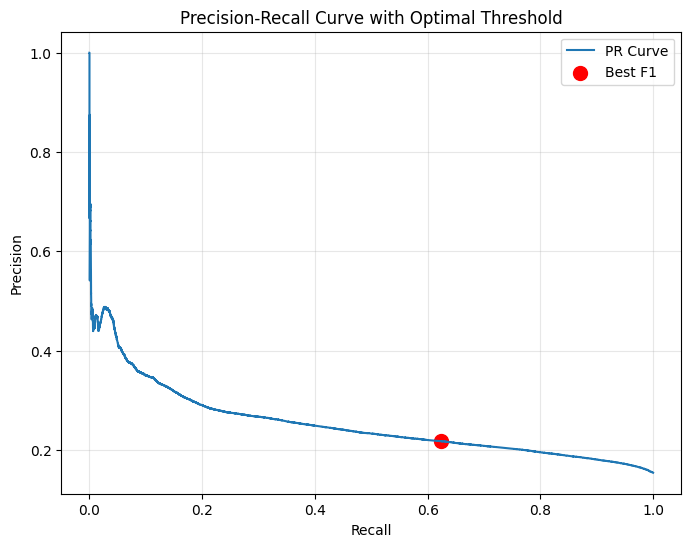

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# 1️⃣ Grid eficiente de thresholds
candidate_thresholds = np.linspace(0, 1, 100)

best_f1 = 0
best_threshold = 0

for t in candidate_thresholds:
    y_pred_temp = (y_proba >= t).astype(int)
    f1 = f1_score(y_test, y_pred_temp)

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print("Best threshold:", best_threshold)
print("Best F1:", best_f1)

# 2️⃣ Calcular precision e recall no threshold ótimo
from sklearn.metrics import precision_score, recall_score

y_best = (y_proba >= best_threshold).astype(int)
best_precision = precision_score(y_test, y_best)
best_recall = recall_score(y_test, y_best)

# 3️⃣ Plotar curva PR
plt.figure(figsize=(8,6))
plt.plot(recall, precision, label="PR Curve")
plt.scatter(best_recall, best_precision, color="red", s=100, label="Best F1")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve with Optimal Threshold")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score

X_train_small = X_train.sample(300_000, random_state=42)
y_train_small = y_train.loc[X_train_small.index]

for c in [0.1, 0.5, 1, 2, 5]:

    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(
            penalty='l2',
            C=c,
            solver='saga',
            max_iter=500,
            class_weight='balanced',
            n_jobs=-1,
            random_state=42
        ))
    ])

    model.fit(X_train_small, y_train_small)  # ← agora sim usa subset
    y_proba = model.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, y_proba)

    print(f"C={c} → AUC={auc:.4f}")


## Treinar 2

In [41]:
anac_df

,airline,flight_number,authorization_code,line_type,origin_airport,destination_airport,year,month,is_delayed,day_of_week,...,temperature_2m,precipitation,wind_speed_10m,critical_hour_x_airline,perfect_storm_score,temperature_anomaly,extreme_temperature_flag,volume_x_hour_risk,last_wave_x_volume,systemic_delay_pressure
0,AZU,2913,0,N,SBFZ,SBRF,2023,1,0,1,...,25.799999,0.0,8.0,0.007616,0.299550,-1.850187,0,3069.067139,0.0,23.375000
1,AZU,2913,0,N,SBFZ,SBRF,2023,1,0,2,...,24.200001,0.2,5.0,0.007616,0.299550,-3.450186,0,3069.067139,0.0,23.375000
2,AZU,2913,0,N,SBFZ,SBRF,2023,1,0,3,...,25.000000,0.0,6.4,0.007616,0.299550,-2.650187,0,3069.067139,0.0,23.375000
3,AZU,2913,0,N,SBFZ,SBRF,2023,1,0,4,...,25.500000,0.0,10.1,0.007616,0.299550,-2.150187,0,3069.067139,0.0,23.375000
4,AZU,2913,0,N,SBFZ,SBRF,2023,1,0,5,...,25.799999,0.0,12.6,0.007616,0.299550,-1.850187,0,3069.067139,0.0,23.375000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2532849,ACA,0091,0,I,SBGR,CYYZ,2025,12,1,1,...,21.799999,1.3,5.9,0.077284,2.644225,1.688007,0,88223.156250,398135.0,6818.201172
2532850,ACA,0091,0,I,SBGR,CYYZ,2025,12,0,3,...,20.799999,0.1,10.1,0.077284,2.644225,0.688007,0,88223.156250,398135.0,6818.201172
2532851,ACA,0091,0,I,SBGR,CYYZ,2025,12,0,1,...,31.100000,0.0,11.8,0.077284,2.644225,10.988008,1,88223.156250,398135.0,6818.201172
2532852,ACA,0091,0,I,SBGR,CYYZ,2025,12,0,3,...,33.000000,0.0,1.5,0.077284,2.644225,12.888008,1,88223.156250,398135.0,6818.201172


In [42]:
anac_df.columns

Index(['airline', 'flight_number', 'authorization_code', 'line_type',
       'origin_airport', 'destination_airport', 'year', 'month', 'is_delayed',
       'day_of_week', 'week_of_year', 'week_of_month', 'hour', 'is_weekend',
       'day_of_year', 'is_holiday', 'is_pre_holiday', 'is_post_holiday',
       'route', 'origin_hour', 'isWeekend_hour', 'holiday_hour',
       'preholiday_hour', 'postholiday_hour', 'airline_hour', 'route_holiday',
       'hour_sin', 'hour_cos', 'is_first_wave', 'is_last_wave',
       'origin_volume', 'destination_volume', 'route_volume',
       'airline_delay_rate', 'hour_delay_rate', 'latitude', 'longitude',
       'origin_type', 'origin_elevation_ft', 'origin_state', 'origin_region',
       'temperature_2m', 'precipitation', 'wind_speed_10m',
       'critical_hour_x_airline', 'perfect_storm_score', 'temperature_anomaly',
       'extreme_temperature_flag', 'volume_x_hour_risk', 'last_wave_x_volume',
       'systemic_delay_pressure'],
      dtype='object')

In [55]:


categorical_cols = [
    'airline',
    'flight_number',
    'authorization_code',
    'line_type',
    'origin_airport',
    'destination_airport',
    'route',
    'origin_hour',
    'airline_hour',
    'route_holiday',
    'origin_type',
    'origin_state',
    'origin_region'
]


binary_cols = [
    'is_weekend',
    'is_holiday',
    'is_pre_holiday',
    'is_post_holiday',
    'isWeekend_hour',
    'holiday_hour',
    'preholiday_hour',
    'postholiday_hour',
    'is_first_wave',
    'is_last_wave',
    'extreme_temperature_flag'
]


continuous_cols = [
    # Temporal numeric
    'month',
    'day_of_week',
    'week_of_year',
    'week_of_month',
    'day_of_year',
    'hour',
    'hour_sin',
    'hour_cos',

    # Volume
    'origin_volume',
    'destination_volume',
    'route_volume',

    # Historical delay rates
    'airline_delay_rate',
    'hour_delay_rate',

    # Geographic
    'latitude',
    'longitude',
    'origin_elevation_ft',

    # Weather
    'temperature_2m',
    'precipitation',
    'wind_speed_10m',
    'temperature_anomaly',

    # Engineered interactions
    'critical_hour_x_airline',
    'perfect_storm_score',
    'volume_x_hour_risk',
    'last_wave_x_volume',
    'systemic_delay_pressure'
]



In [56]:
for col in categorical_cols:
    anac_df[col] = anac_df[col].astype('category')

for col in continuous_cols:
    anac_df[col] = anac_df[col].astype(float)


In [57]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

preprocessor = ColumnTransformer(
    transformers=[
        ('cont', StandardScaler(), continuous_cols),
        ('bin', 'passthrough', binary_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)


In [58]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        penalty='l2',
        C=0.5,
        solver='saga',
        max_iter=500,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    ))
])


In [59]:
train = anac_df[anac_df['year'].isin([2023, 2024])].copy()
test  = anac_df[anac_df['year'] == 2025].copy()

X_train = train.drop(columns=['is_delayed','year'])
y_train = train['is_delayed']

X_test = test.drop(columns=['is_delayed','year'])
y_test = test['is_delayed']


In [60]:
model.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cont', StandardScaler(),
                                                  ['month', 'day_of_week',
                                                   'week_of_year',
                                                   'week_of_month',
                                                   'day_of_year', 'hour',
                                                   'hour_sin', 'hour_cos',
                                                   'origin_volume',
                                                   'destination_volume',
                                                   'route_volume',
                                                   'airline_delay_rate',
                                                   'hour_delay_rate',
                                                   'latitude', 'longitude',
                                                   'origin_elevation_ft',
                                                   'temperature_2m',
                                                   'precipitat...
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['airline', 'flight_number',
                                                   'authorization_code',
                                                   'line_type',
                                                   'origin_airport',
                                                   'destination_airport',
                                                   'route', 'origin_hour',
                                                   'airline_hour',
                                                   'route_holiday',
                                                   'origin_type',
                                                   'origin_state',
                                                   'origin_region'])])),
                ('classifier',
                 LogisticRegression(C=0.5, class_weight='balanced',
                                    max_iter=500, n_jobs=-1, random_state=42,
                                    solver='saga'))])

## Métricas

In [61]:
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       0.90      0.60      0.72    705639
           1       0.22      0.61      0.32    128346

    accuracy                           0.60    833985
   macro avg       0.56      0.61      0.52    833985
weighted avg       0.79      0.60      0.66    833985

AUC: 0.6532087348397443
